In [1]:
import pandas as pd
import numpy as np
import math
import json
import os

from tqdm import tqdm
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set(rc={'figure.figsize':(24, 15)}, font_scale=2)

from glob import glob

import sys
sys.path.append('../')
import utils

Importing plotly failed. Interactive plots will not work.


# Functions

In [ ]:
def get_real_and_predicted_ranges(regions_df, clusters_df, cluster_points_bounds=False):
    '''
    Given the `regions_df` and the `clusters_df` extract the real and predicted anomalous regions
    
    Notice that the predicted anomalous regions are set to be equal to the number of the true regions
    and the order they are picked is specified by the order of the rows in the `clusters_df`
    '''
    # Extract the real anomaly ranges and the predicted anomaly ranges
    real_ranges = []
    predicted_ranges = []
    for _, row in regions_df.iterrows():
        real_ranges.append([row['unix_start'], row['unix_end']])
    for _, row in clusters_df.iterrows():
        if cluster_points_bounds:
            predicted_ranges.append([row['point_start'], row['point_end']])
        else:
            predicted_ranges.append([row['start'], row['end']])
    predicted_ranges = predicted_ranges[:len(real_ranges)]

    return real_ranges, predicted_ranges


def get_regions_coverage(regions_df, clusters_df, cluster_points_bounds=False):
    '''
    Given the `regions_df` and the top-k `cluster_df` check if a region is covered by at least one top-k cluster

    Returns a modified `regions_df` dataframe with the column `region_covered_by_top_k_cluster` which is a binary column
    '''
    # Process alerts_df to check for accuracy and what region it corresponds to if it is correct
    regions_df['region_covered_by_top_k_cluster'] = np.nan
    for index, region in regions_df.iterrows():
        overlap_found = 0
        for _, cluster in clusters_df.iterrows():

            region_interval = [region['unix_start'], region['unix_end']]

            if cluster_points_bounds:
                cluster_interval = [cluster['point_start'], cluster['point_end']]
            else:
                cluster_interval = [cluster['start'], cluster['end']]

            if utils.metrics.regions_overlap(region_interval, cluster_interval):
                overlap_found = 1

        regions_df.loc[index, 'region_covered_by_top_k_cluster'] = overlap_found

    return regions_df

def get_avg_num_clusters_per_region(regions_df, clusters_df):
    '''
    Given the `regions_df` and the `clusters_df` compute the average number of clusters present in each true region
    '''
    num_clusters_per_region = []
    for _, region in regions_df.iterrows():
        num_clusters = 0
        region_interval = [region['unix_start'], region['unix_end']]
        for _, cluster in clusters_df.iterrows():
            cluster_interval = [cluster['start'], cluster['end']]
            if utils.metrics.regions_overlap(region_interval, cluster_interval):
                num_clusters +=1 
        num_clusters_per_region.append(num_clusters)

    return np.mean(num_clusters_per_region)

def get_avg_num_regions_per_cluster(regions_df, clusters_df):
    num_regions_per_cluster = []
    for _, cluster in clusters_df.iterrows():
        num_regions = 0
        cluster_interval = [cluster['start'], cluster['end']]
        for _, region in regions_df.iterrows():
            region_interval = [region['unix_start'], region['unix_end']]
            if utils.metrics.regions_overlap(cluster_interval, region_interval):
                num_regions +=1 
        num_regions_per_cluster.append(num_regions)

    return np.mean(num_regions_per_cluster)


def get_k_mean_clusters(points, n_clusters=2):
    '''
    Given a set of points return the clusters by running kmean as well as the cluster boundaries and centers
    '''
    X = np.array(points).reshape(-1,1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    cluster_centers = sorted(kmeans.cluster_centers_)

    # Extract the boundaries for each cluster
    cluster_boundaries = []
    for i in range(len(cluster_centers) - 1):
        boundary = (cluster_centers[i] + cluster_centers[i+1]) / 2
        cluster_boundaries.append(boundary[0])
    cluster_boundaries = sorted(cluster_boundaries)

    clusters_dict = {'cluster_id': [], 'start': [], 'end': []}
    for cluster_id in range(len(cluster_boundaries) + 1):
        clusters_dict['cluster_id'].append(cluster_id)
        if cluster_id==0:
            clusters_dict['start'].append(np.min(points))
            clusters_dict['end'].append(cluster_boundaries[cluster_id])
        elif cluster_id==len(cluster_boundaries):
            clusters_dict['start'].append(cluster_boundaries[cluster_id-1])
            clusters_dict['end'].append(np.max(points))
        else:
            clusters_dict['start'].append(cluster_boundaries[cluster_id-1])
            clusters_dict['end'].append(cluster_boundaries[cluster_id])
    clusters_df = pd.DataFrame.from_dict(clusters_dict)

    return clusters_df, cluster_boundaries, cluster_centers


def get_all_outlier_timestamps(df):
    timestamps = []
    for _, row in df[df['raw_voting_score'] > 0].iterrows():
        votes = row['raw_voting_score']
        time = row['unix_time']
        for i in range(votes):
            timestamps.append(time)
    return timestamps


def get_k_means_figure(df, outliers, cluster_centers, cluster_boundaries, savepath):
    df = df.sort_values(by='timestamp')

    # Plot the Figure
    fig, axs = plt.subplots(2, sharex=True)
    fig.subplots_adjust(hspace=0)

    axs[0].plot(df['unix_time'], df['measure'])
    axs[0].scatter(df[df['is_outlier']==1]['unix_time'].values, df[df['is_outlier']==1]['measure'].values, s=90, c='red', zorder=10, label='True Injected Outliers')
    axs[0].scatter(df[df['raw_voting_score']>0]['unix_time'].values, df[df['raw_voting_score']>0]['measure'].values, s=30, c='green', zorder=10, label='Detected Outliers')
    axs[0].set_ylabel('Measure');axs[0].legend()

    axs[0].vlines(cluster_boundaries, -1.5, 1.5, colors='red', zorder=10)

    axs[1].scatter(outliers, np.zeros_like(outliers), marker='.', s=300, label='Timestamps of Outliers')
    axs[1].scatter(cluster_centers, np.zeros_like(cluster_centers), marker='x', s=400, color='red', label='Cluster Centroid')
    axs[1].vlines(cluster_boundaries, -0.1, 0.1, colors='red')
    axs[1].set_xlabel('Unix Time');axs[1].legend()
    plt.tight_layout()
    plt.savefig(savepath + 'timeseries_k_means_plot.svg')
    plt.close()
    

# All Outlier Types Experiment

In [94]:
def all_outlier_types_experiment(dir_paths, cluster_points_bounds=False):
    precision_list = [];recall_list = []
    precision_k_means_list = []; recall_k_means_list = []
    avg_num_clusters_per_region_list = [];avg_num_top_k_clusters_per_region_list = [];avg_num_regions_per_top_k_cluster_list = []
    regions_df_list = []

    for path in tqdm(dir_paths):
        regions_df = pd.read_pickle(path + 'regions_df.pickle')
        df = pd.read_pickle(path + 'df.pickle').sort_values(by='unix_time')
        clusters_df = pd.read_pickle(path + 'clusters_df.pickle').sort_values(by='area', ascending=False)

        # Add unix time to the regions_df
        regions_df['unix_start'] = df.loc[regions_df['start']]['unix_time'].values
        regions_df['unix_end'] = df.loc[regions_df['end']]['unix_time'].values

        # Get the true regions coverage information given the top-k clusters
        regions_df = get_regions_coverage(regions_df, clusters_df.head(len(regions_df.index)), cluster_points_bounds=cluster_points_bounds)
        regions_df['run_id'] = os.path.basename(os.path.dirname(path))
        regions_df_list.append(regions_df)

        # Compute the range-based precision and recall
        real_ranges, predicted_ranges = get_real_and_predicted_ranges(regions_df, clusters_df, cluster_points_bounds=cluster_points_bounds)
        recall = utils.metrics.range_based_recall(real_ranges=real_ranges, predicted_ranges=predicted_ranges, alpha=1, delta_mode='flat')
        precision = utils.metrics.range_based_precision(real_ranges=real_ranges, predicted_ranges=predicted_ranges, delta_mode='flat')
        precision_list.append(precision)
        recall_list.append(recall)
        

        # Extract timestamps of all detected outliers (each vote is counted separately)
        outlier_timestamps = get_all_outlier_timestamps(df)
        k_mean_clusters_df, cluster_boundaries, cluster_centers = get_k_mean_clusters(outlier_timestamps, n_clusters=len(regions_df.index))
        get_k_means_figure(df, outlier_timestamps, cluster_centers, cluster_boundaries, savepath=path+'figures/')

        # Compute precision and recall for k-means
        real_ranges, predicted_ranges = get_real_and_predicted_ranges(regions_df, k_mean_clusters_df)
        recall_kmeans = utils.metrics.range_based_recall(real_ranges=real_ranges, predicted_ranges=predicted_ranges, alpha=1, delta_mode='flat')
        precision_kmeans = utils.metrics.range_based_precision(real_ranges=real_ranges, predicted_ranges=predicted_ranges, delta_mode='flat')
        precision_k_means_list.append(precision_kmeans);recall_k_means_list.append(recall_kmeans)


        # Compute the average number of clusters per region and vice versa
        avg_num_clusters_per_region_list.append(get_avg_num_clusters_per_region(regions_df, clusters_df))
        avg_num_top_k_clusters_per_region_list.append(get_avg_num_clusters_per_region(regions_df, clusters_df.head(len(regions_df.index))))
        avg_num_regions_per_top_k_cluster_list.append(get_avg_num_regions_per_cluster(regions_df, clusters_df.head(len(regions_df.index))))

    
    evaluation_dict = {
        'precision': precision_list, 'recall': recall_list, 'precision_kmeans': precision_k_means_list, 'recall_kmeans': recall_k_means_list, 'avg_num_clusters_per_region': avg_num_clusters_per_region_list,
        'avg_num_top_k_clusters_per_region': avg_num_top_k_clusters_per_region_list, 'seed': list(range(1, len(precision_list) + 1))
    }
    evaluation_df = pd.DataFrame.from_dict(evaluation_dict)
    
    regions_combined_df = pd.concat(regions_df_list)
    regions_combined_df = regions_combined_df.groupby(['injection_mode']).agg(['mean', 'std'])['region_covered_by_top_k_cluster']

    return evaluation_df, regions_combined_df

## Full Cluster Bounds

### Original

In [95]:
dir_paths = sorted(glob("../synthetic_data/synthetic_experiments/all_outlier_types_095/*/"))
evaluation_df, regions_combined_df = all_outlier_types_experiment(dir_paths)

100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


In [96]:
print("Mean/SDEV: Range-Based Precision:", evaluation_df['precision'].mean(), evaluation_df['precision'].std())
print("Mean/SDEV Range-Based Recall:", evaluation_df['recall'].mean(), evaluation_df['recall'].std())
regions_combined_df

Mean/SDEV: Range-Based Precision: 0.10607927734826521 0.010068606349893386
Mean/SDEV Range-Based Recall: 0.86 0.08432740427115679


,mean,std
injection_mode,,
high_residual_consistent,0.848485,0.364110
high_residual_nearest,0.764706,0.430562
level_shift,0.969697,0.174078


### Adjusted

In [97]:
dir_paths = sorted(glob("../synthetic_data/synthetic_experiments/all_outlier_types_098/*/"))
evaluation_df, regions_combined_df = all_outlier_types_experiment(dir_paths)

100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


In [98]:
print("Mean/SDEV: Range-Based Precision:", evaluation_df['precision'].mean(), evaluation_df['precision'].std())
print("Mean/SDEV Range-Based Recall:", evaluation_df['recall'].mean(), evaluation_df['recall'].std())
regions_combined_df

Mean/SDEV: Range-Based Precision: 0.10909035144045834 0.012797052758775851
Mean/SDEV Range-Based Recall: 0.9800000000000001 0.06324555320336758


,mean,std
injection_mode,,
high_residual_consistent,0.939394,0.242306
high_residual_nearest,1.000000,0.000000
level_shift,1.000000,0.000000


## Tight Cluster Bounds

### Original

In [99]:
dir_paths = sorted(glob("../synthetic_data/synthetic_experiments/all_outlier_types_095/*/"))
evaluation_df, regions_combined_df = all_outlier_types_experiment(dir_paths, cluster_points_bounds=True)

100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


In [100]:
print("Mean/SDEV: Range-Based Precision:", evaluation_df['precision'].mean(), evaluation_df['precision'].std())
print("Mean/SDEV Range-Based Recall:", evaluation_df['recall'].mean(), evaluation_df['recall'].std())

Mean/SDEV: Range-Based Precision: 0.1823941415874955 0.027575352070549404
Mean/SDEV Range-Based Recall: 0.86 0.08432740427115679


### Adjusted

In [101]:
dir_paths = sorted(glob("../synthetic_data/synthetic_experiments/all_outlier_types_098/*/"))
evaluation_df, regions_combined_df = all_outlier_types_experiment(dir_paths, cluster_points_bounds=True)

100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


In [102]:
print("Mean/SDEV: Range-Based Precision:", evaluation_df['precision'].mean(), evaluation_df['precision'].std())
print("Mean/SDEV Range-Based Recall:", evaluation_df['recall'].mean(), evaluation_df['recall'].std())

Mean/SDEV: Range-Based Precision: 0.42344772768866523 0.059232193621522176
Mean/SDEV Range-Based Recall: 0.9800000000000001 0.06324555320336758


# Injection Rate Experiment

In [110]:
def injection_rate_experiment(dir_paths, cluster_points_bounds=False):
    precision_list = [];recall_list = []
    precision_k_means_list = []; recall_k_means_list = []
    avg_num_clusters_per_region_list = [];avg_num_top_k_clusters_per_region_list = []
    regions_df_list = []
    injection_rate_list = []

    for path in tqdm(dir_paths):
        dir_paths_local = sorted(glob(path+'/*/'))

        temp_precision = [];temp_recall = []
        temp_precision_k_means_list = []; temp_recall_k_means_list = []
        avg_num_clusters_per_region_tmp = [];avg_num_top_k_clusters_per_region_tmp = []
        injection_rate = os.path.basename(os.path.dirname(path)).split('_')[1]
        
        for path_local in dir_paths_local:

            regions_df = pd.read_pickle(path_local + 'regions_df.pickle')
            df = pd.read_pickle(path_local + 'df.pickle').sort_values(by='unix_time')
            clusters_df = pd.read_pickle(path_local + 'clusters_df.pickle').sort_values(by='area', ascending=False)

            # Add unix time to the regions_df
            regions_df['unix_start'] = df.loc[regions_df['start']]['unix_time'].values
            regions_df['unix_end'] = df.loc[regions_df['end']]['unix_time'].values

            # Get the true regions coverage information given the top-k clusters
            regions_df = get_regions_coverage(regions_df, clusters_df.head(len(regions_df.index)), cluster_points_bounds=cluster_points_bounds)
            regions_df['injection_rate'] = injection_rate
            regions_df_list.append(regions_df)

            # Compute the range-based precision and recall
            real_ranges, predicted_ranges = get_real_and_predicted_ranges(regions_df, clusters_df, cluster_points_bounds=cluster_points_bounds)
            recall = utils.metrics.range_based_recall(real_ranges=real_ranges, predicted_ranges=predicted_ranges, alpha=1, delta_mode='flat')
            precision = utils.metrics.range_based_precision(real_ranges=real_ranges, predicted_ranges=predicted_ranges, delta_mode='flat')
            temp_precision.append(precision)
            temp_recall.append(recall)

            # Extract timestamps of all detected outliers (each vote is counted separately)
            outlier_timestamps = get_all_outlier_timestamps(df)
            k_mean_clusters_df, cluster_boundaries, cluster_centers = get_k_mean_clusters(outlier_timestamps, n_clusters=len(regions_df.index))
            get_k_means_figure(df, outlier_timestamps, cluster_centers, cluster_boundaries, savepath=path_local+'figures/')

            # Compute precision and recall for k-means
            real_ranges, predicted_ranges = get_real_and_predicted_ranges(regions_df, k_mean_clusters_df)
            recall_kmeans = utils.metrics.range_based_recall(real_ranges=real_ranges, predicted_ranges=predicted_ranges, alpha=1, delta_mode='flat')
            precision_kmeans = utils.metrics.range_based_precision(real_ranges=real_ranges, predicted_ranges=predicted_ranges, delta_mode='flat')
            temp_precision_k_means_list.append(precision_kmeans);temp_recall_k_means_list.append(recall_kmeans)

            # Compute the average number of clusters per region and vice versa
            avg_num_clusters_per_region_tmp.append(get_avg_num_clusters_per_region(regions_df, clusters_df))
            avg_num_top_k_clusters_per_region_tmp.append(get_avg_num_clusters_per_region(regions_df, clusters_df.head(len(regions_df.index))))
        
        precision_list.append(np.mean(temp_precision))
        recall_list.append(np.mean(temp_recall))
        precision_k_means_list.append(np.mean(temp_precision_k_means_list));recall_k_means_list.append(np.mean(temp_recall_k_means_list))

        avg_num_clusters_per_region_list.append(np.mean(avg_num_clusters_per_region_tmp))
        avg_num_top_k_clusters_per_region_list.append(np.mean(avg_num_top_k_clusters_per_region_tmp))

        injection_rate_list.append(injection_rate)


    evaluation_dict = {
        'precision': precision_list, 'recall': recall_list, 'precision_kmeans': precision_k_means_list, 'recall_kmeans': recall_k_means_list, 'avg_num_clusters_per_region': avg_num_clusters_per_region_list,
        'avg_num_top_k_clusters_per_region': avg_num_top_k_clusters_per_region_list, 'injection_rate': injection_rate_list
    }

    evaluation_df = pd.DataFrame.from_dict(evaluation_dict)
    f1_scores = (2 * np.array(precision_list) * np.array(recall_list)) / (np.array(precision_list) + np.array(recall_list))
    f1_scores_kmeans = (2 * np.array(precision_k_means_list) * np.array(recall_k_means_list)) / (np.array(precision_k_means_list) + np.array(recall_k_means_list))
    evaluation_df['f1_score'] = f1_scores
    evaluation_df['f1_score_kmeans'] = f1_scores_kmeans

    regions_combined_df = pd.concat(regions_df_list)
    regions_combined_df = regions_combined_df.groupby(['injection_rate','injection_mode']).mean()
    regions_combined_df = regions_combined_df.reset_index()

    return evaluation_df, regions_combined_df

## Full Cluster Bounds

In [123]:
dir_paths = sorted(glob("../synthetic_data/synthetic_experiments/injection_rate_095/*/"))
evaluation_df, regions_combined_df = injection_rate_experiment(dir_paths, cluster_points_bounds=False)

100%|██████████| 15/15 [00:38<00:00,  2.60s/it]


In [116]:
dir_paths_adj = sorted(glob("../synthetic_data/synthetic_experiments/injection_rate_098/*/"))
evaluation_df_adj, regions_combined_df_adj = injection_rate_experiment(dir_paths_adj, cluster_points_bounds=False)

100%|██████████| 15/15 [00:35<00:00,  2.34s/it]


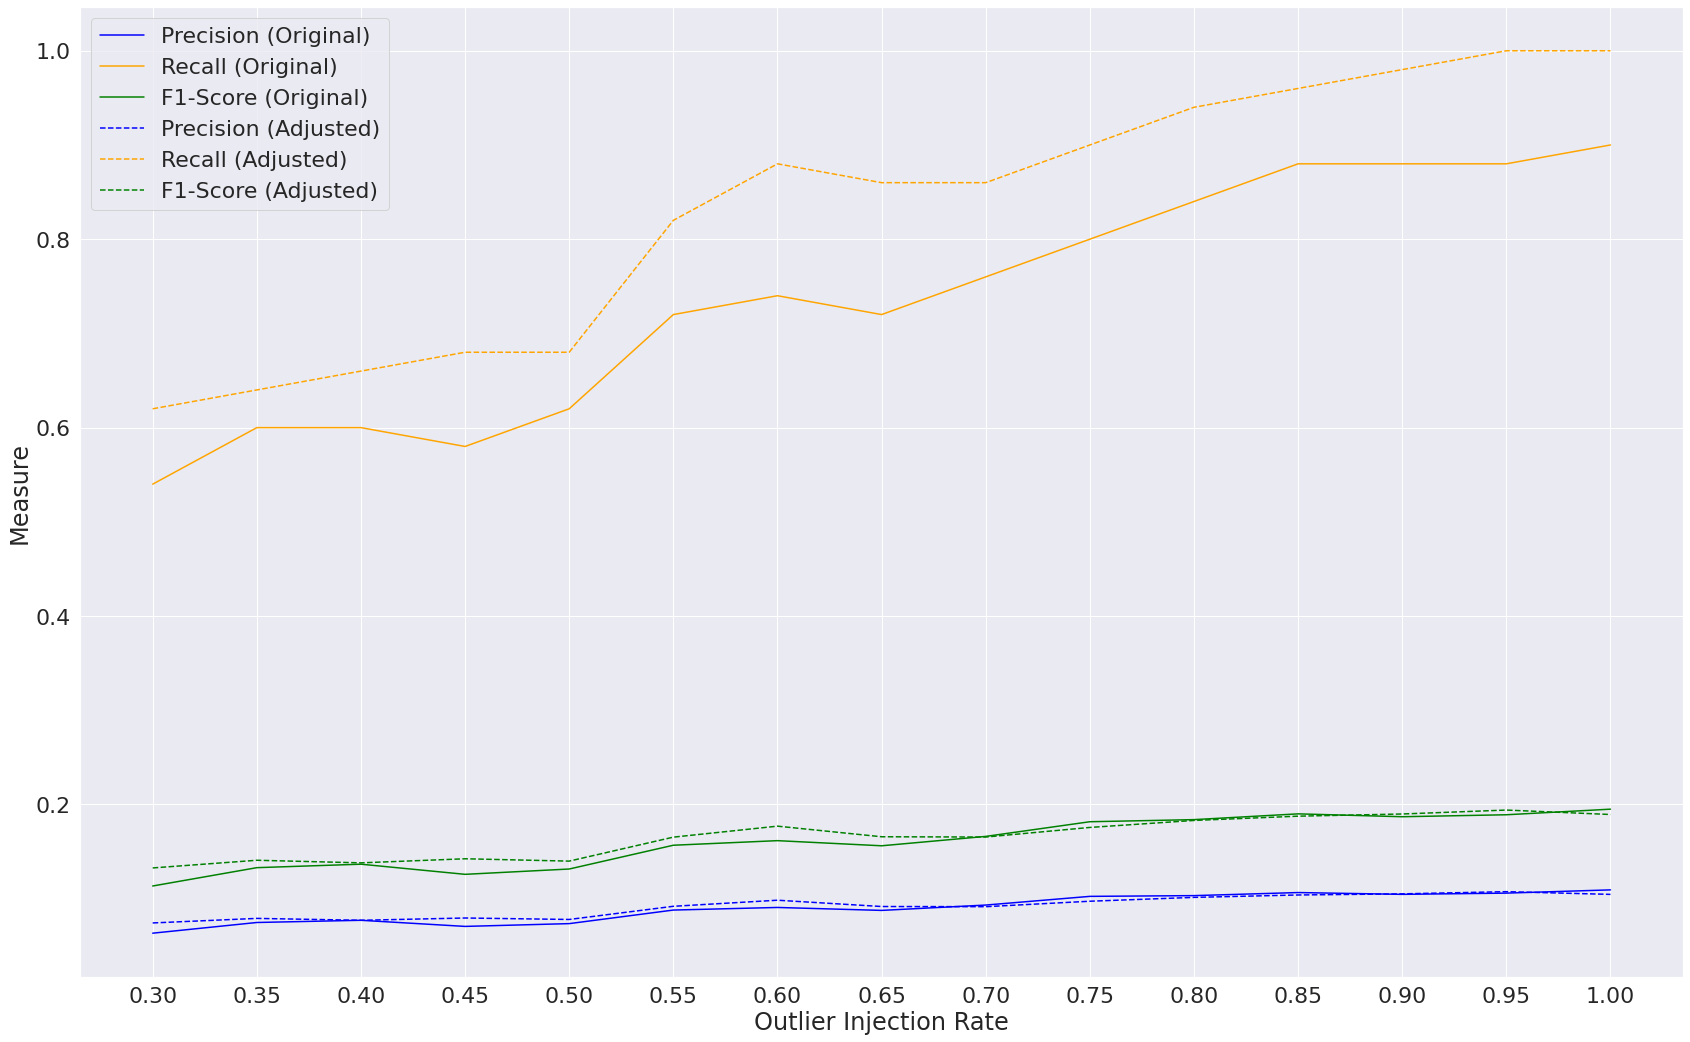

In [118]:
plt.plot(evaluation_df['injection_rate'], evaluation_df['precision'], color='blue', label='Precision (Original)')
plt.plot(evaluation_df['injection_rate'], evaluation_df['recall'], color='orange', label='Recall (Original)')
plt.plot(evaluation_df['injection_rate'], evaluation_df['f1_score'], color='green', label='F1-Score (Original)')

plt.plot(evaluation_df_adj['injection_rate'], evaluation_df_adj['precision'], '--', color='blue', label='Precision (Adjusted)')
plt.plot(evaluation_df_adj['injection_rate'], evaluation_df_adj['recall'], '--', color='orange', label='Recall (Adjusted)')
plt.plot(evaluation_df_adj['injection_rate'], evaluation_df_adj['f1_score'], '--', color='green', label='F1-Score (Adjusted)')

plt.xlabel('Outlier Injection Rate');plt.ylabel('Measure');plt.legend();plt.tight_layout()
plt.savefig('../figures/synthetic_experiments/outlier_injection_rate_original_vs_adjusted.svg')

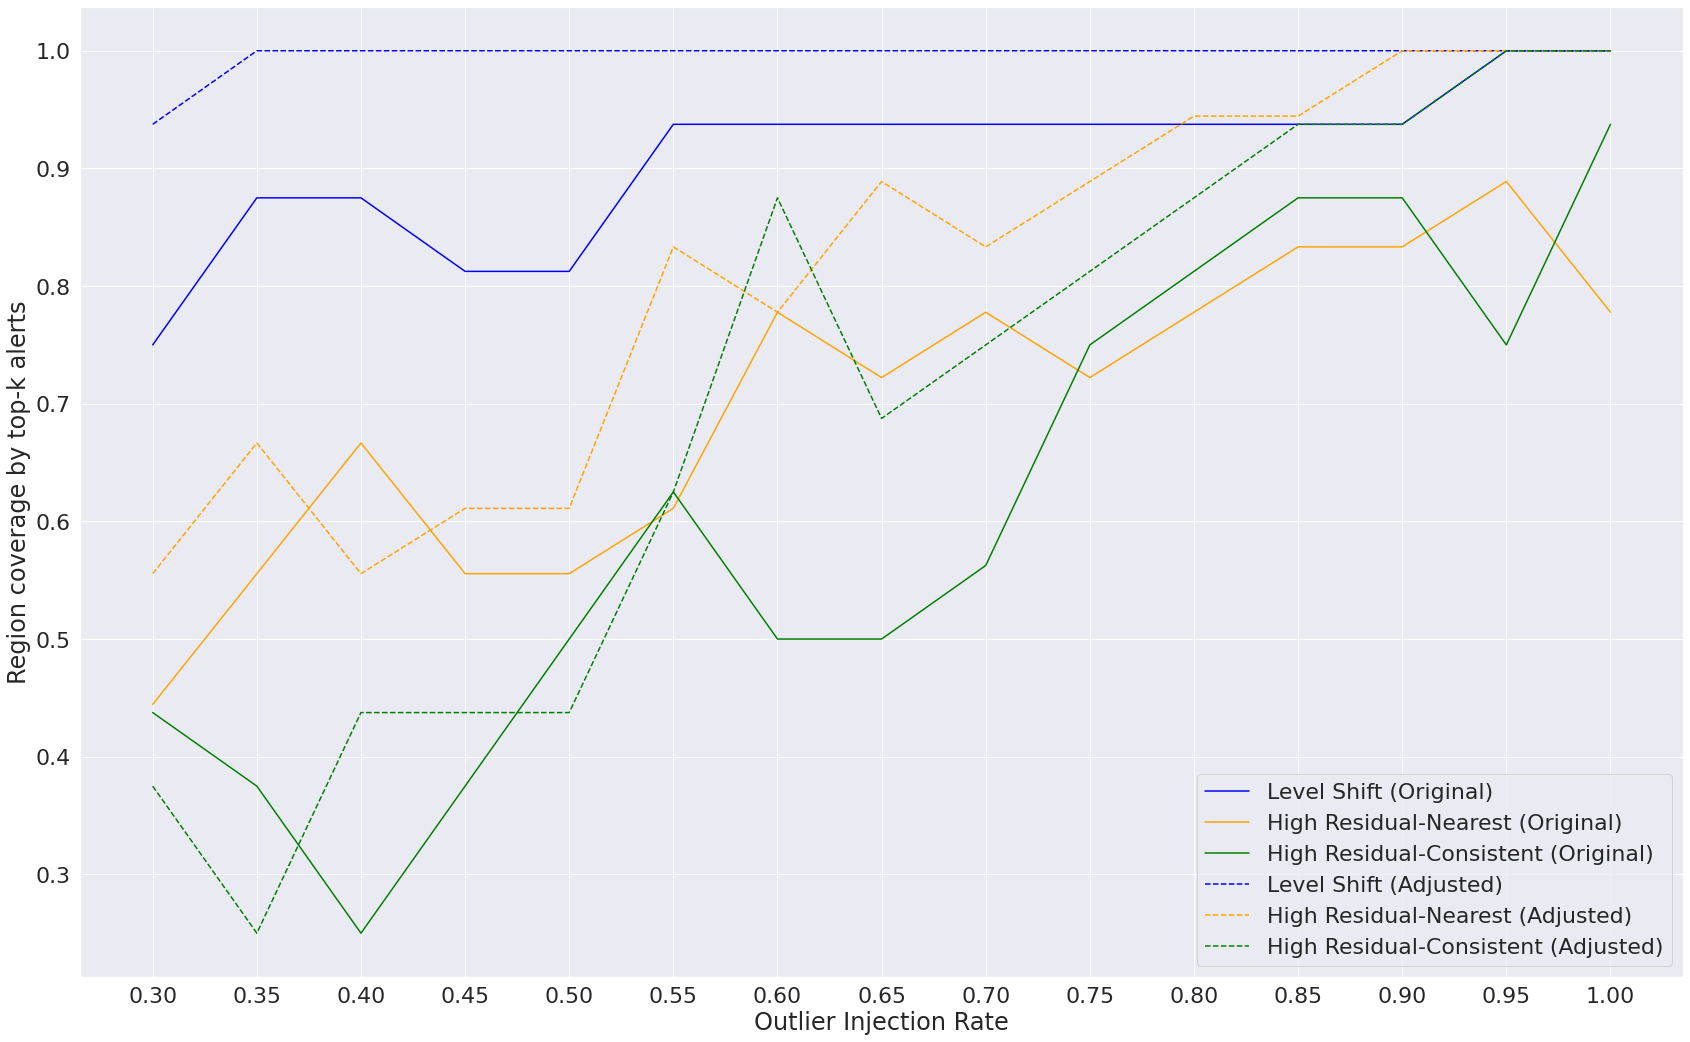

In [128]:
plt.plot(regions_combined_df[regions_combined_df['injection_mode']=='level_shift']['injection_rate'], regions_combined_df[regions_combined_df['injection_mode']=='level_shift']['region_covered_by_top_k_cluster'], color='blue', label='Level Shift (Original)')
plt.plot(regions_combined_df[regions_combined_df['injection_mode']=='high_residual_nearest']['injection_rate'], regions_combined_df[regions_combined_df['injection_mode']=='high_residual_nearest']['region_covered_by_top_k_cluster'], color='orange', label='High Residual-Nearest (Original)')
plt.plot(regions_combined_df[regions_combined_df['injection_mode']=='high_residual_consistent']['injection_rate'], regions_combined_df[regions_combined_df['injection_mode']=='high_residual_consistent']['region_covered_by_top_k_cluster'], color='green', label='High Residual-Consistent (Original)')

plt.plot(regions_combined_df_adj[regions_combined_df_adj['injection_mode']=='level_shift']['injection_rate'], regions_combined_df_adj[regions_combined_df_adj['injection_mode']=='level_shift']['region_covered_by_top_k_cluster'],
    '--', color='blue', label='Level Shift (Adjusted)')
plt.plot(regions_combined_df_adj[regions_combined_df_adj['injection_mode']=='high_residual_nearest']['injection_rate'], regions_combined_df_adj[regions_combined_df_adj['injection_mode']=='high_residual_nearest']['region_covered_by_top_k_cluster'],
    '--', color='orange', label='High Residual-Nearest (Adjusted)')
plt.plot(regions_combined_df_adj[regions_combined_df_adj['injection_mode']=='high_residual_consistent']['injection_rate'], regions_combined_df_adj[regions_combined_df_adj['injection_mode']=='high_residual_consistent']['region_covered_by_top_k_cluster'],
    '--', color='green', label='High Residual-Consistent (Adjusted)')

plt.xlabel('Outlier Injection Rate');plt.ylabel('Region coverage by top-k alerts');plt.legend();plt.tight_layout()
plt.savefig('../figures/synthetic_experiments/outlier_injection_rate_vs_region_coverage_original_vs_adjusted.svg')

## Tight Cluster Bounds

In [129]:
dir_paths = sorted(glob("../synthetic_data/synthetic_experiments/injection_rate_095/*/"))
evaluation_tight_df, regions_combined_tight_df = injection_rate_experiment(dir_paths, cluster_points_bounds=True)

100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


In [130]:
dir_paths_adj = sorted(glob("../synthetic_data/synthetic_experiments/injection_rate_098/*/"))
evaluation_tight_df_adj, regions_combined_tight_df_adj = injection_rate_experiment(dir_paths_adj, cluster_points_bounds=True)

100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


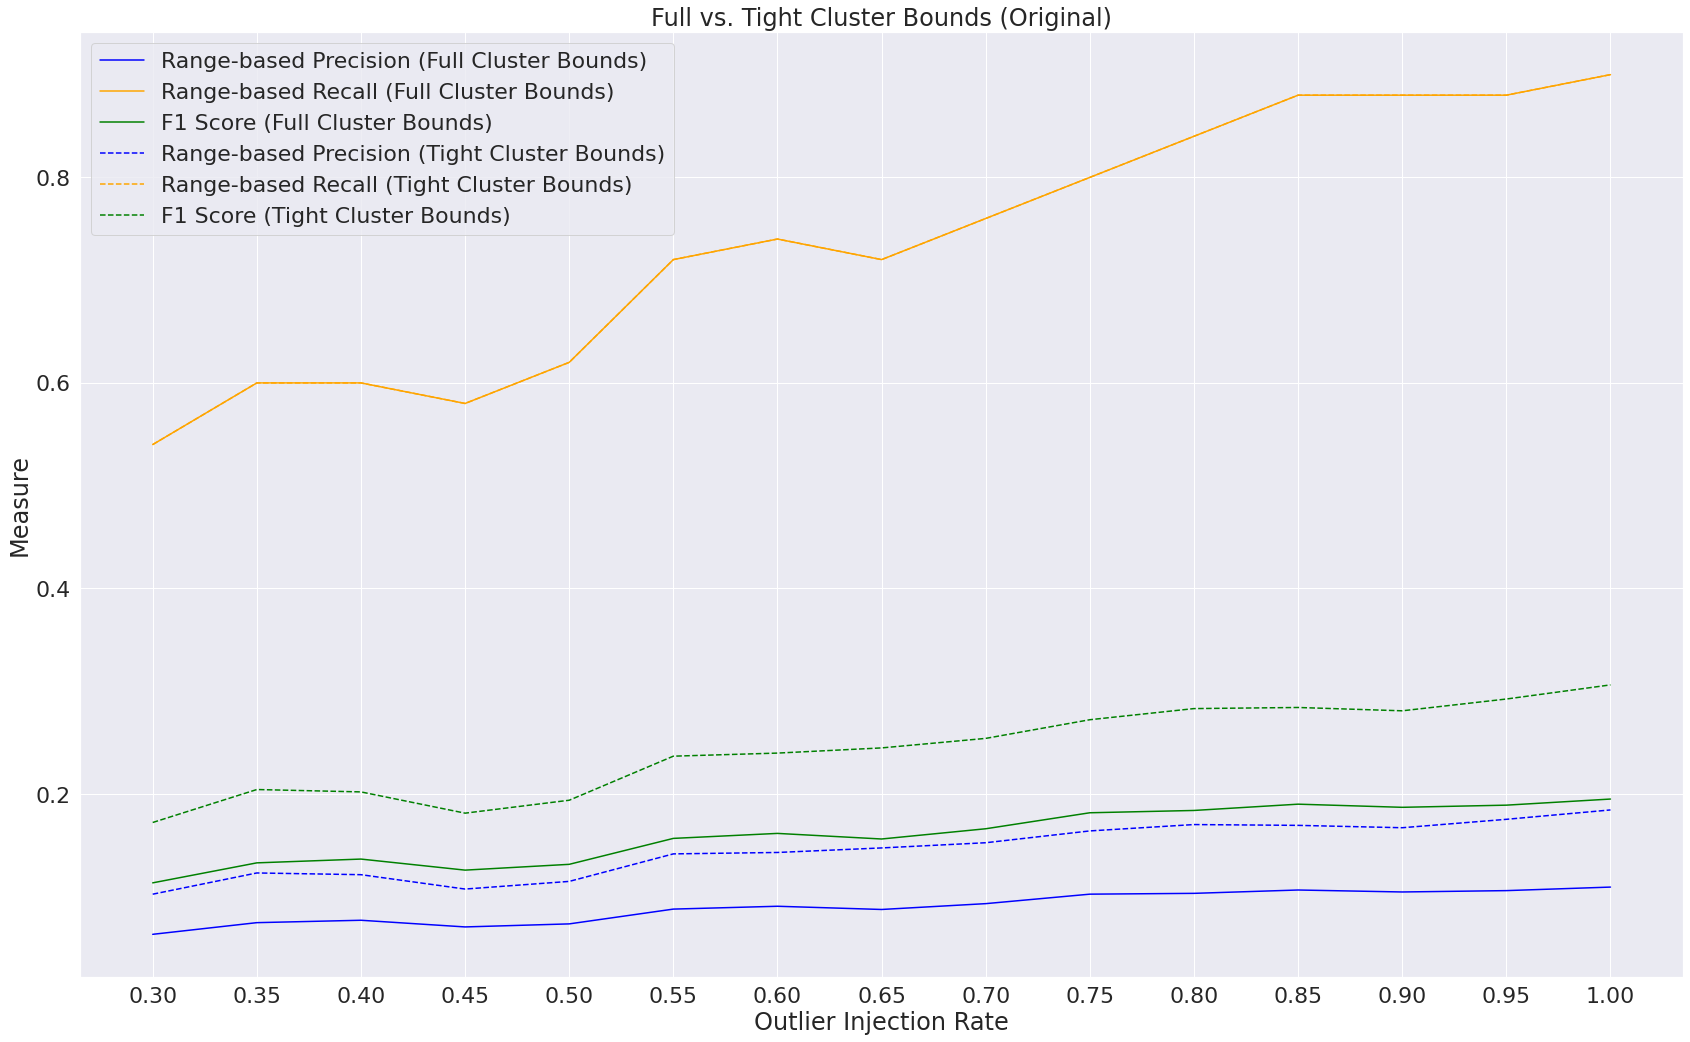

In [132]:
plt.plot(evaluation_df['injection_rate'], evaluation_df['precision'], color='blue', label='Range-based Precision (Full Cluster Bounds)')
plt.plot(evaluation_df['injection_rate'], evaluation_df['recall'],color='orange', label='Range-based Recall (Full Cluster Bounds)')
plt.plot(evaluation_df['injection_rate'], evaluation_df['f1_score'], color='green', label='F1 Score (Full Cluster Bounds)')
plt.plot(evaluation_tight_df['injection_rate'], evaluation_tight_df['precision'], '--', color='blue', label='Range-based Precision (Tight Cluster Bounds)')
plt.plot(evaluation_tight_df['injection_rate'], evaluation_tight_df['recall'], '--', color='orange', label='Range-based Recall (Tight Cluster Bounds)')
plt.plot(evaluation_tight_df['injection_rate'], evaluation_tight_df['f1_score'], '--', color='green', label='F1 Score (Tight Cluster Bounds)')
plt.xlabel('Outlier Injection Rate');plt.ylabel('Measure');plt.legend();plt.title('Full vs. Tight Cluster Bounds (Original)');plt.tight_layout()
plt.savefig('../figures/synthetic_experiments/outlier_injection_rate_full_vs_tight_bounds_original.svg')

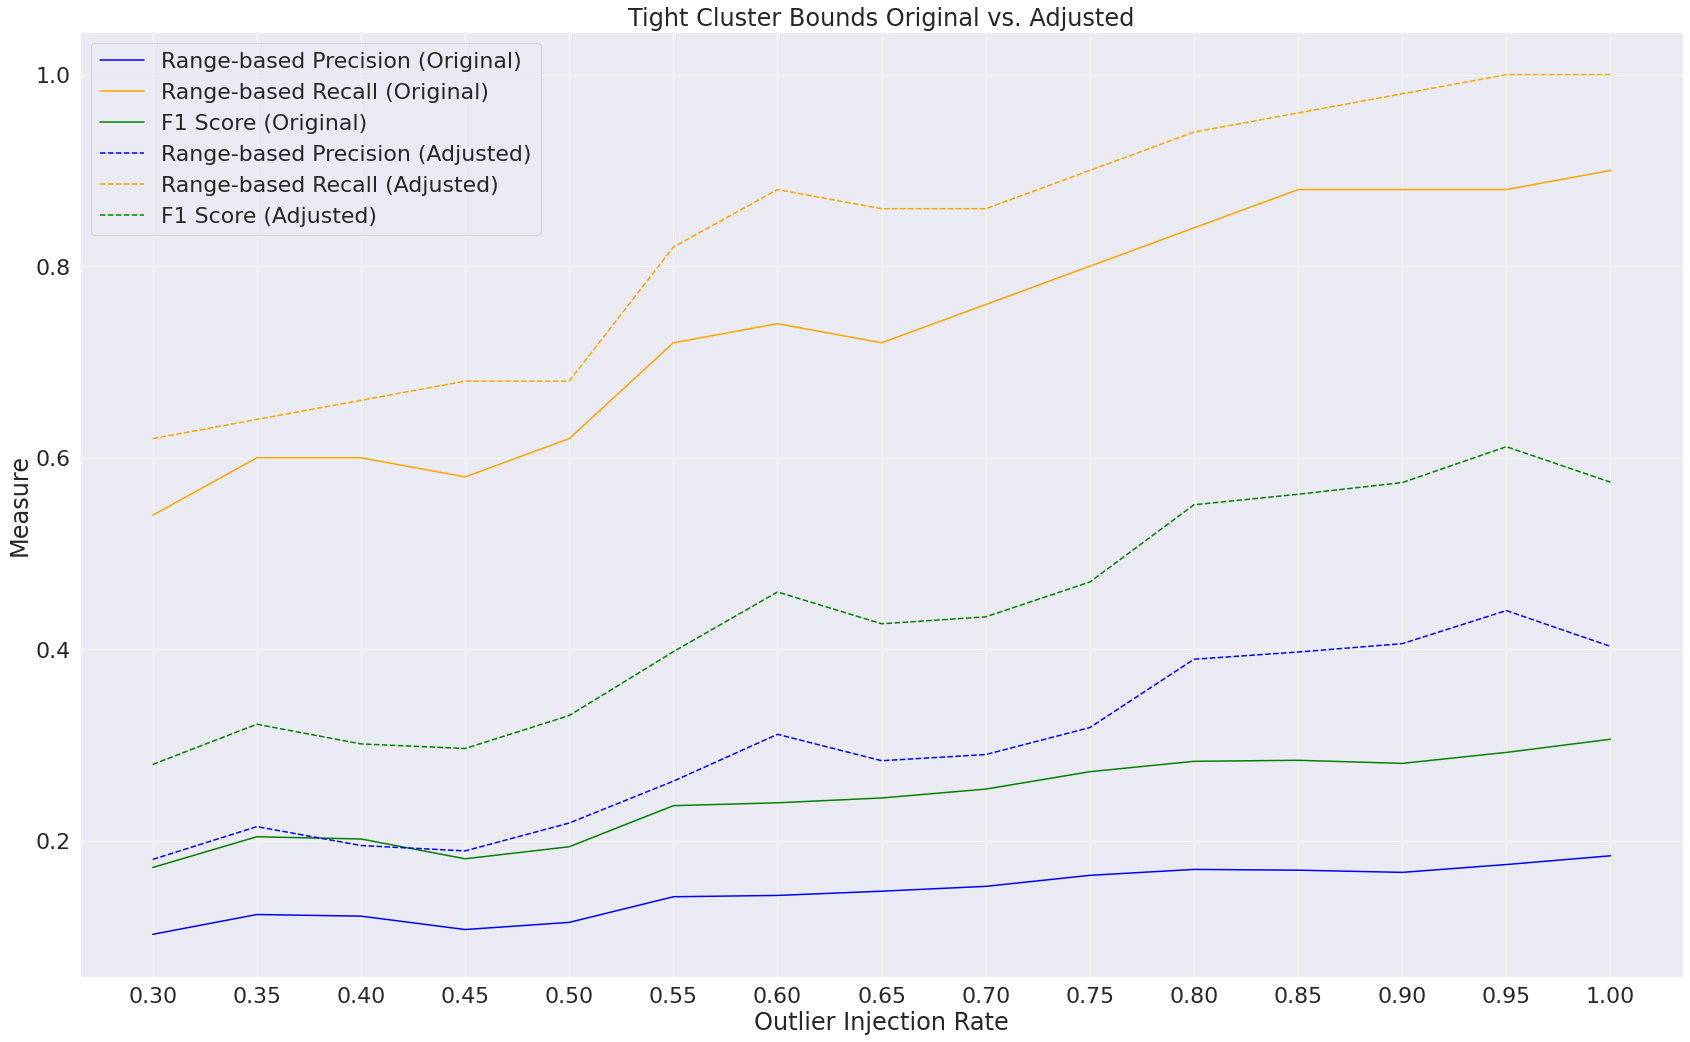

In [136]:
plt.plot(evaluation_tight_df['injection_rate'], evaluation_tight_df['precision'], color='blue', label='Range-based Precision (Original)')
plt.plot(evaluation_tight_df['injection_rate'], evaluation_tight_df['recall'],color='orange', label='Range-based Recall (Original)')
plt.plot(evaluation_tight_df['injection_rate'], evaluation_tight_df['f1_score'], color='green', label='F1 Score (Original)')
plt.plot(evaluation_tight_df_adj['injection_rate'], evaluation_tight_df_adj['precision'], '--', color='blue', label='Range-based Precision (Adjusted)')
plt.plot(evaluation_tight_df_adj['injection_rate'], evaluation_tight_df_adj['recall'], '--', color='orange', label='Range-based Recall (Adjusted)')
plt.plot(evaluation_tight_df_adj['injection_rate'], evaluation_tight_df_adj['f1_score'], '--', color='green', label='F1 Score (Adjusted)')
plt.xlabel('Outlier Injection Rate');plt.ylabel('Measure');plt.legend();plt.title('Tight Cluster Bounds Original vs. Adjusted');plt.tight_layout()
plt.savefig('../figures/synthetic_experiments/outlier_injection_rate_tight_bounds_original_vs_adjusted.svg')

# Variable Region Length Experiment

In [34]:
def variable_region_experiment(dir_paths, cluster_points_bounds=False):
    precision_list = []
    recall_list = []
    avg_num_clusters_per_region_list = [];avg_num_top_k_clusters_per_region_list = []    
    regions_df_list = []
    region_length_list = []

    for path in dir_paths:
        dir_paths_local = sorted(glob(path+'/*/'))

        temp_precision = []
        temp_recall = []
        avg_num_clusters_per_region_tmp = [];avg_num_top_k_clusters_per_region_tmp = []

        region_length_min = int(os.path.basename(os.path.dirname(path)).split('_')[1])
        region_length_max = int(os.path.basename(os.path.dirname(path)).split('_')[2])
        region_length = region_length_max - region_length_min
        
        for path_local in dir_paths_local:

            regions_df = pd.read_pickle(path_local + 'regions_df.pickle')
            df = pd.read_pickle(path_local + 'df.pickle').sort_values(by='unix_time')
            clusters_df = pd.read_pickle(path_local + 'clusters_df.pickle').sort_values(by='area', ascending=False)

            # Add unix time to the regions_df
            regions_df['unix_start'] = df.loc[regions_df['start']]['unix_time'].values
            regions_df['unix_end'] = df.loc[regions_df['end']]['unix_time'].values

            # Get the true regions coverage information given the top-k clusters
            regions_df = get_regions_coverage(regions_df, clusters_df.head(len(regions_df.index)), cluster_points_bounds=cluster_points_bounds)
            regions_df['region_length'] = region_length
            regions_df_list.append(regions_df)

            # Compute the range-based precision and recall
            real_ranges, predicted_ranges = get_real_and_predicted_ranges(regions_df, clusters_df, cluster_points_bounds=cluster_points_bounds)
            recall = utils.metrics.range_based_recall(real_ranges=real_ranges, predicted_ranges=predicted_ranges, alpha=1, delta_mode='flat')
            precision = utils.metrics.range_based_precision(real_ranges=real_ranges, predicted_ranges=predicted_ranges, delta_mode='flat')
            temp_precision.append(precision)
            temp_recall.append(recall)

            # Compute the average number of clusters per region and vice versa
            avg_num_clusters_per_region_tmp.append(get_avg_num_clusters_per_region(regions_df, clusters_df))
            avg_num_top_k_clusters_per_region_tmp.append(get_avg_num_clusters_per_region(regions_df, clusters_df.head(len(regions_df.index))))
        
        precision_list.append(np.mean(temp_precision))
        recall_list.append(np.mean(temp_recall))
        avg_num_clusters_per_region_list.append(np.mean(avg_num_clusters_per_region_tmp))
        avg_num_top_k_clusters_per_region_list.append(np.mean(avg_num_top_k_clusters_per_region_tmp))
        region_length_list.append(region_length)


    evaluation_dict = {
        'precision': precision_list, 'recall': recall_list, 'avg_num_clusters_per_region': avg_num_clusters_per_region_list,
        'avg_num_top_k_clusters_per_region': avg_num_top_k_clusters_per_region_list, 'region_length': region_length_list
    }
    evaluation_df = pd.DataFrame.from_dict(evaluation_dict)
    f1_scores = (2 * np.array(precision_list) * np.array(recall_list)) / (np.array(precision_list) + np.array(recall_list))
    evaluation_df['f1_score'] = f1_scores

    return evaluation_df, regions_df_list


## Full Cluster Bounds

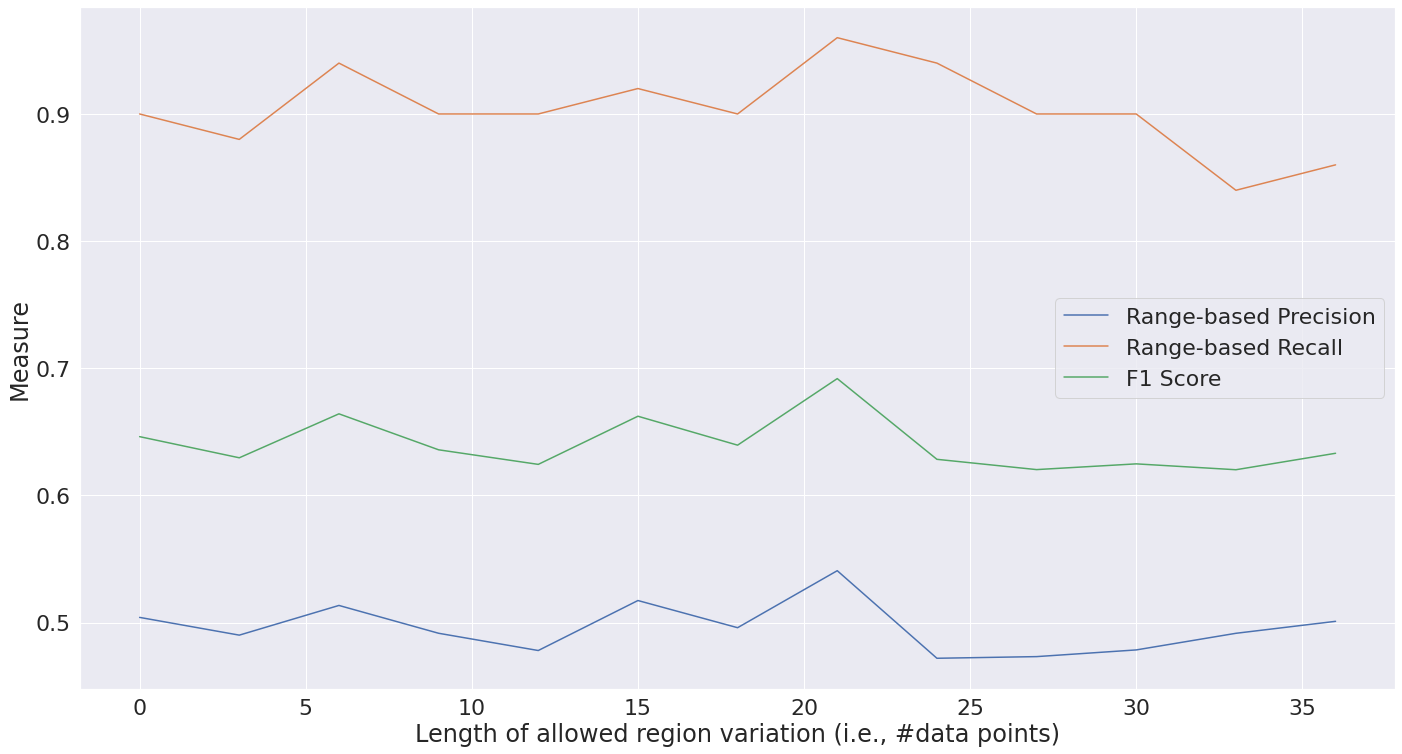

In [35]:
dir_paths = sorted(glob("../synthetic_data/synthetic_experiments/variable_region_length/*/"))
evaluation_df, regions_df_list = variable_region_experiment(dir_paths, cluster_points_bounds=False)
plt.plot(evaluation_df['region_length'], evaluation_df['precision'], label='Range-based Precision')
plt.plot(evaluation_df['region_length'], evaluation_df['recall'], label='Range-based Recall')
plt.plot(evaluation_df['region_length'], evaluation_df['f1_score'], label='F1 Score')

plt.xlabel('Length of allowed region variation (i.e., #data points)');plt.ylabel('Measure');plt.legend();plt.tight_layout()
plt.savefig('../figures/synthetic_experiments/variable_region_length_vs_eval_measures.svg')

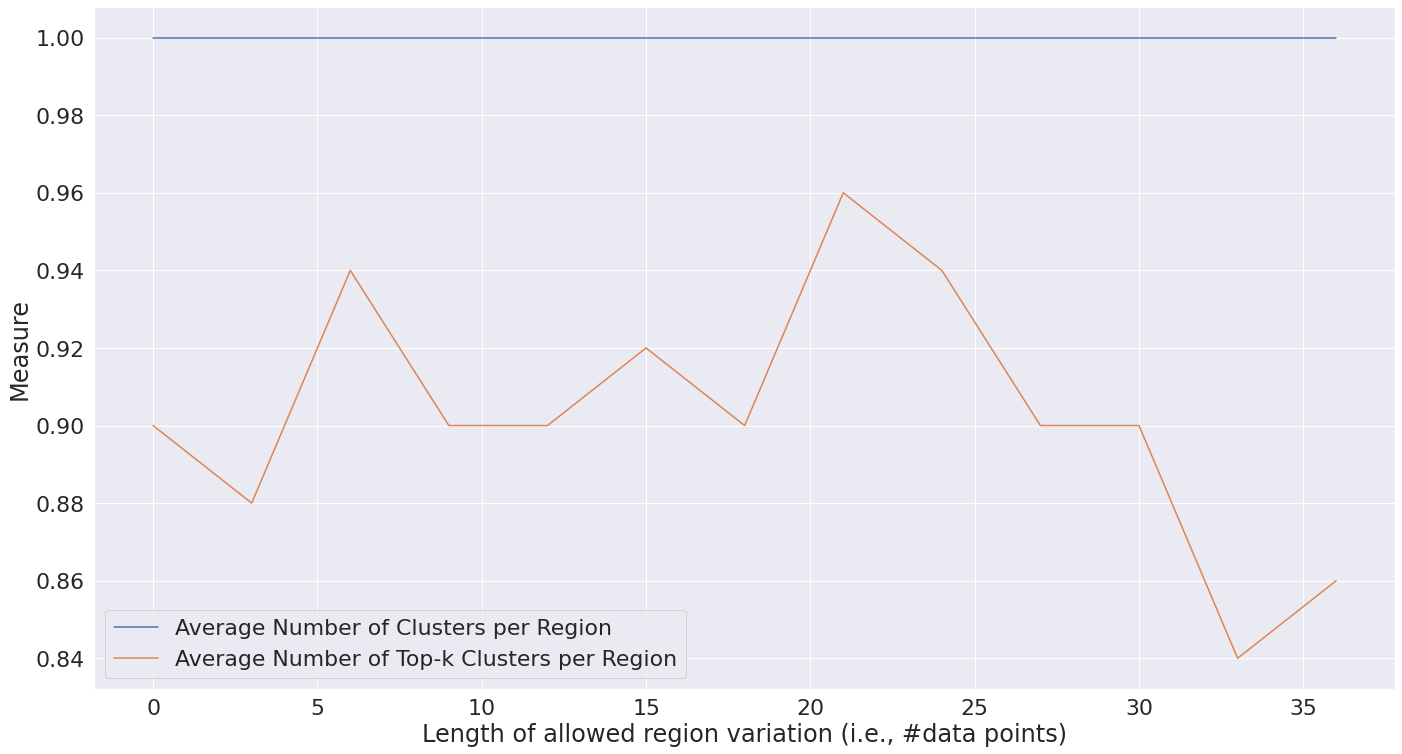

In [37]:
plt.plot(evaluation_df['region_length'], evaluation_df['avg_num_clusters_per_region'], label='Average Number of Clusters per Region')
plt.plot(evaluation_df['region_length'], evaluation_df['avg_num_top_k_clusters_per_region'], label='Average Number of Top-k Clusters per Region')

plt.xlabel('Length of allowed region variation (i.e., #data points)');plt.ylabel('Measure');plt.legend();plt.tight_layout()

## Tight Cluster Bounds

In [32]:
dir_paths = sorted(glob("../synthetic_data/synthetic_experiments/variable_region_length/*/"))
evaluation_tight_df, regions_tight_df_list = variable_region_experiment(dir_paths, cluster_points_bounds=True)

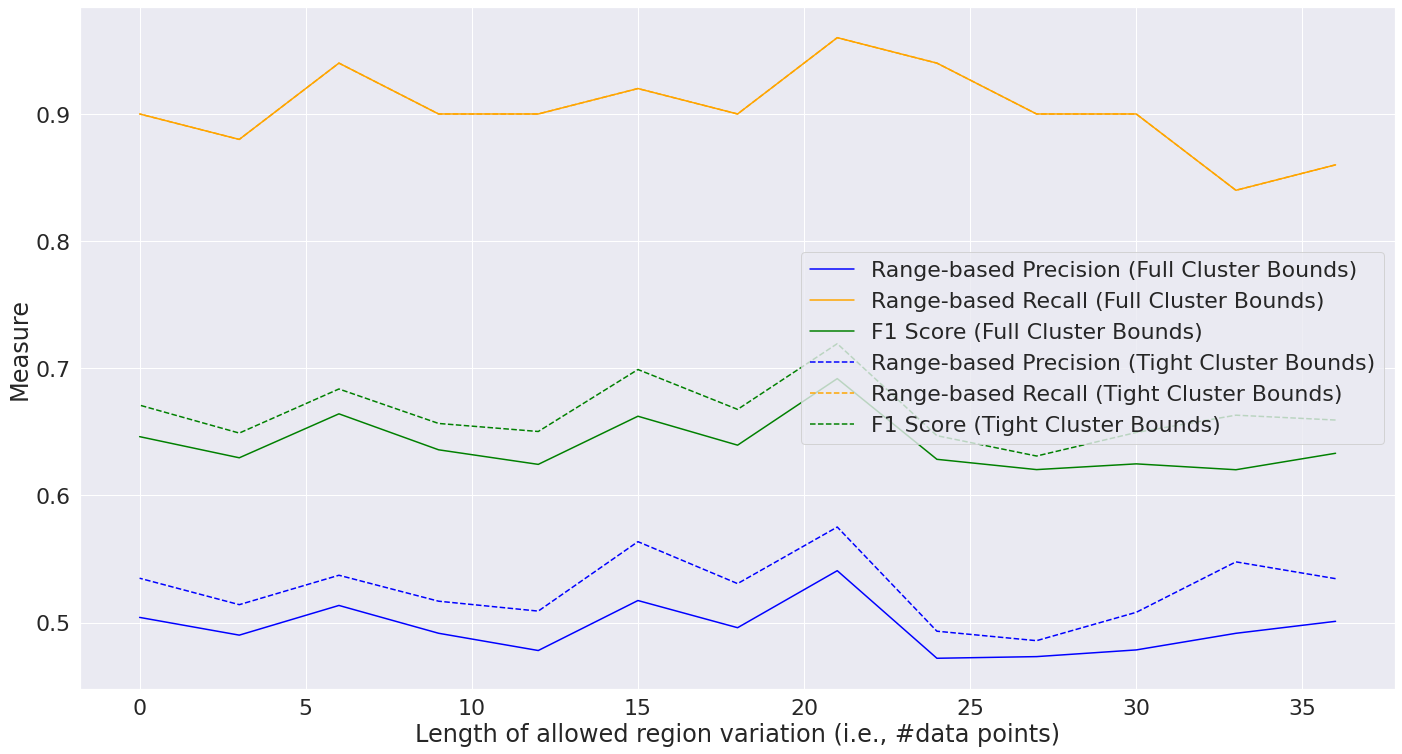

In [33]:
plt.plot(evaluation_df['region_length'], evaluation_df['precision'], color='blue', label='Range-based Precision (Full Cluster Bounds)')
plt.plot(evaluation_df['region_length'], evaluation_df['recall'],color='orange', label='Range-based Recall (Full Cluster Bounds)')
plt.plot(evaluation_df['region_length'], evaluation_df['f1_score'], color='green', label='F1 Score (Full Cluster Bounds)')
plt.plot(evaluation_tight_df['region_length'], evaluation_tight_df['precision'], '--', color='blue', label='Range-based Precision (Tight Cluster Bounds)')
plt.plot(evaluation_tight_df['region_length'], evaluation_tight_df['recall'], '--', color='orange', label='Range-based Recall (Tight Cluster Bounds)')
plt.plot(evaluation_tight_df['region_length'], evaluation_tight_df['f1_score'], '--', color='green', label='F1 Score (Tight Cluster Bounds)')
plt.xlabel('Length of allowed region variation (i.e., #data points)');plt.ylabel('Measure');plt.legend();plt.tight_layout()

plt.savefig('../figures/synthetic_experiments/variable_region_length_vs_eval_measures_tight_vs_full_bounds.svg')

# Kmeans Evaluation

In [131]:
from sklearn.cluster import KMeans

def get_clusters(points, n_clusters=2):
    '''
    Given a set of points return the clusters by running kmean as well as the cluster boundaries and centers
    '''
    X = np.array(points).reshape(-1,1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    cluster_centers = sorted(kmeans.cluster_centers_)

    # Extract the boundaries for each cluster
    cluster_boundaries = []
    for i in range(len(cluster_centers) - 1):
        boundary = (cluster_centers[i] + cluster_centers[i+1]) / 2
        cluster_boundaries.append(boundary[0])
    cluster_boundaries = sorted(cluster_boundaries)

    clusters_dict = {'cluster_id': [], 'start': [], 'end': []}
    for cluster_id in range(len(cluster_boundaries) + 1):
        clusters_dict['cluster_id'].append(cluster_id)
        if cluster_id==0:
            clusters_dict['start'].append(np.min(points))
            clusters_dict['end'].append(cluster_boundaries[cluster_id])
        elif cluster_id==len(cluster_boundaries):
            clusters_dict['start'].append(cluster_boundaries[cluster_id-1])
            clusters_dict['end'].append(np.max(points))
        else:
            clusters_dict['start'].append(cluster_boundaries[cluster_id-1])
            clusters_dict['end'].append(cluster_boundaries[cluster_id])
    clusters_df = pd.DataFrame.from_dict(clusters_dict)

    return clusters_df, cluster_boundaries, cluster_centers

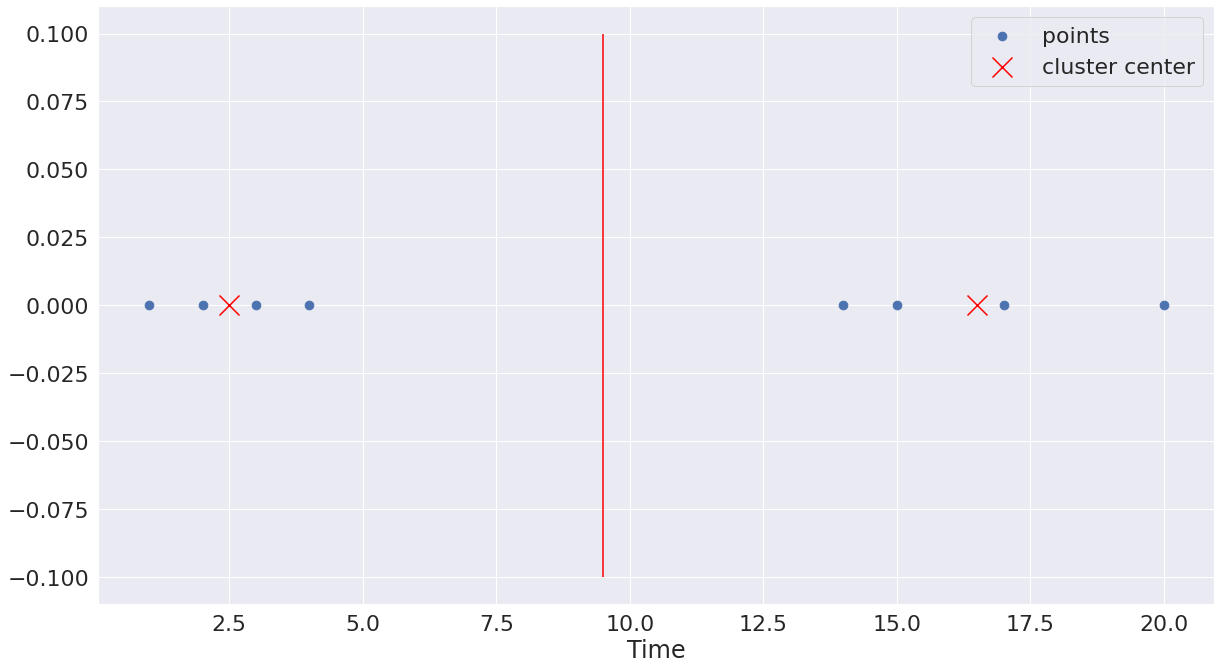

In [13]:
points = [1,2,3,4,14,15,17,20]

clusters_df, cluster_boundaries, cluster_centers = get_k_mean_clusters(points, n_clusters=2)


plt.scatter(points, np.zeros_like(points), marker='.', s=300, label='points')
plt.scatter(cluster_centers, np.zeros_like(cluster_centers), marker='x', s=400, color='red', label='cluster center')
plt.vlines(cluster_boundaries, -0.1, 0.1, colors='red')
plt.xlabel('Time');plt.legend()
plt.savefig('../figures/synthetic_experiments/kmeans_examples/example1.svg')

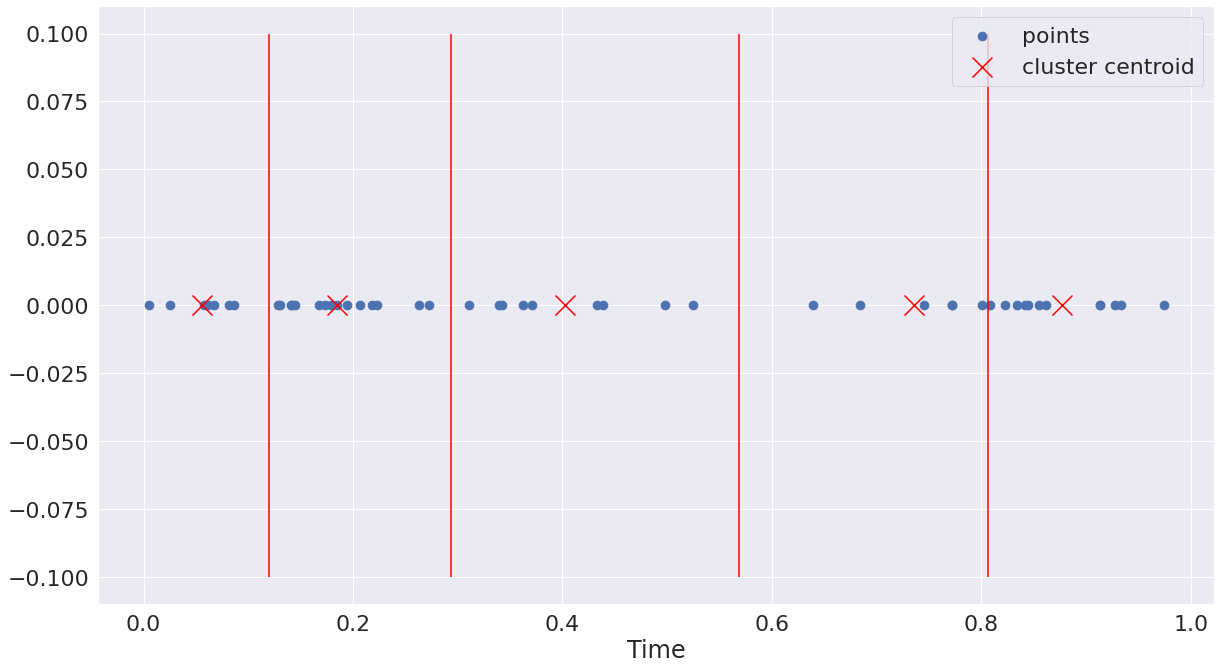

In [15]:
points = np.random.rand(50)

clusters_df, cluster_boundaries, cluster_centers = get_k_mean_clusters(points, n_clusters=5)

plt.scatter(points, np.zeros_like(points), marker='.', s=300, label='points')
plt.scatter(cluster_centers, np.zeros_like(cluster_centers), marker='x', s=400, color='red', label='cluster centroid')
plt.vlines(cluster_boundaries, -0.1, 0.1, colors='red')
plt.xlabel('Time');plt.legend()
plt.savefig('../figures/synthetic_experiments/kmeans_examples/example2.svg')

# Testing

In [3]:
path = "../synthetic_data/synthetic_experiments/injection_rate/rate_0.50/seed1/"
regions_df = pd.read_pickle(path + 'regions_df.pickle')
df = pd.read_pickle(path + 'df.pickle').sort_values(by='unix_time')
clusters_df = pd.read_pickle(path + 'clusters_df.pickle').sort_values(by='area', ascending=False)

# Add unix time to the regions_df
regions_df['unix_start'] = df.loc[regions_df['start']]['unix_time'].values
regions_df['unix_end'] = df.loc[regions_df['end']]['unix_time'].values

# Get the true regions coverage information given the top-k clusters
regions_df = get_regions_coverage(regions_df, clusters_df.head(len(regions_df.index)), cluster_points_bounds=True)

regions_df

,region_id,start,end,length,injection_mode,unix_start,unix_end,region_covered_by_top_k_cluster
0,0,1033,1056,24,level_shift,1.594688e+09,1.594771e+09,1.0
1,1,1931,1954,24,high_residual_consistent,1.597921e+09,1.598004e+09,1.0
2,2,2201,2224,24,level_shift,1.598893e+09,1.598976e+09,1.0
3,3,3439,3462,24,high_residual_consistent,1.603350e+09,1.603433e+09,0.0
4,4,4179,4202,24,high_residual_consistent,1.606014e+09,1.606097e+09,1.0
5,5,6219,6242,24,high_residual_nearest,1.613358e+09,1.613441e+09,1.0
6,6,7364,7387,24,level_shift,1.617480e+09,1.617563e+09,0.0
7,7,7737,7760,24,high_residual_nearest,1.618823e+09,1.618906e+09,0.0
8,8,8117,8140,24,high_residual_consistent,1.620191e+09,1.620274e+09,1.0
9,9,9325,9348,24,high_residual_consistent,1.624540e+09,1.624622e+09,1.0


In [6]:


# Compute the range-based precision and recall
real_ranges, predicted_ranges = get_real_and_predicted_ranges(regions_df, clusters_df, cluster_points_bounds=True)
recall = utils.metrics.range_based_recall(real_ranges=real_ranges, predicted_ranges=predicted_ranges, alpha=1, delta_mode='flat')
precision = utils.metrics.range_based_precision(real_ranges=real_ranges, predicted_ranges=predicted_ranges, delta_mode='flat')

print("Precision:", precision, '\n\n\n\n')

# Extract timestamps of all detected outliers (each vote is counted separately)
outlier_timestamps = get_all_outlier_timestamps(df)
k_mean_clusters_df, cluster_boundaries, cluster_centers = get_k_mean_clusters(outlier_timestamps, n_clusters=len(regions_df.index))
get_k_means_figure(df, outlier_timestamps, cluster_centers, cluster_boundaries, savepath=path+'figures/')

# Compute precision and recall for k-means
real_ranges, predicted_ranges = get_real_and_predicted_ranges(regions_df, k_mean_clusters_df)
recall_kmeans = utils.metrics.range_based_recall(real_ranges=real_ranges, predicted_ranges=predicted_ranges, alpha=1, delta_mode='flat')
precision_kmeans = utils.metrics.range_based_precision(real_ranges=real_ranges, predicted_ranges=predicted_ranges, delta_mode='flat')
print("K-means precision:", precision_kmeans)

print(real_ranges)
print(predicted_ranges)

0.5310077519379846
0.5423728813559322
0
0.6137339055793991
0.6454545454545455
0
0.25333333333333335
0.5161290322580645
0
0.6526717557251909
Precision: 0.375470320564445 




0
0.5888051668460711
0.5168650793650794
0.1359026369168357
0.42573320719016083
0
0.4424357754519505
0.29838056680161945
0.8320675105485232
0.7664921465968586
K-means precision: 0.4006682089717099
[[1594688400.0, 1594771200.0], [1597921200.0, 1598004000.0], [1598893200.0, 1598976000.0], [1603350000.0, 1603432800.0], [1606014000.0, 1606096800.0], [1613358000.0, 1613440800.0], [1617480000.0, 1617562800.0], [1618822800.0, 1618905600.0], [1620190800.0, 1620273600.0], [1624539600.0, 1624622400.0]]
[[1591009200.0, 1593314694.0052896], [1593314694.0052896, 1596657132.6067276], [1596657132.6067276, 1600283775.523221], [1600283775.523221, 1603831754.4827585], [1603831754.4827585, 1607635491.4285715], [1607635491.4285715, 1611251159.3406594], [1611251159.3406594, 1615032596.3154492], [1615032596.3154492, 1619476622.8033614], 

In [25]:
k = 10
k_clusters = clusters.sort_values(by='area', ascending=False).head(k).reset_index()
k_clusters

,index,cluster_id,start,end,point_start,point_end,time_length,num_points,area,area_pts
0,6,6,1.594190e+09,1.595253e+09,1.594253e+09,1.595178e+09,1.063130e+06,58,0.081336,0.080080
1,15,15,1.598635e+09,1.599159e+09,1.598699e+09,1.599120e+09,5.243653e+05,29,0.045007,0.043124
2,41,41,1.612364e+09,1.613129e+09,1.612375e+09,1.613092e+09,7.643494e+05,40,0.040948,0.039477
3,29,29,1.605832e+09,1.606488e+09,1.605874e+09,1.606266e+09,6.563566e+05,27,0.036501,0.031409
4,63,63,1.624169e+09,1.625149e+09,1.624216e+09,1.625051e+09,9.803352e+05,33,0.033823,0.032590
5,42,42,1.613129e+09,1.613629e+09,1.613196e+09,1.613527e+09,5.003669e+05,22,0.030872,0.025605
6,56,56,1.619654e+09,1.620940e+09,1.619863e+09,1.620803e+09,1.286315e+06,28,0.030078,0.029186
7,24,24,1.602878e+09,1.603739e+09,1.603080e+09,1.603584e+09,8.615430e+05,27,0.028509,0.025852
8,39,39,1.611429e+09,1.612015e+09,1.611598e+09,1.611904e+09,5.855613e+05,23,0.025711,0.016913
9,54,54,1.618378e+09,1.619072e+09,1.618592e+09,1.619014e+09,6.935541e+05,21,0.024246,0.021652


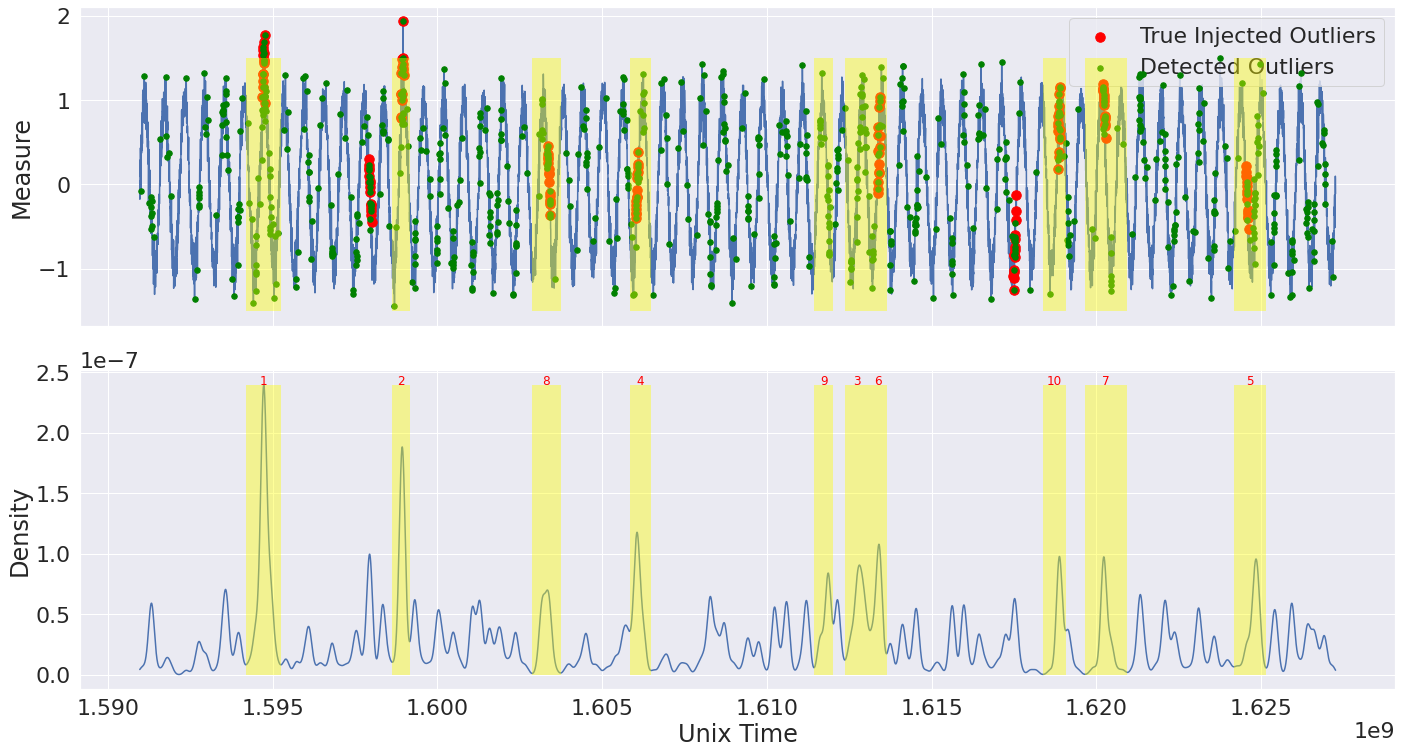

In [35]:
    df = df.sort_values(by='timestamp')

    # Plot the Figure
    fig, axs = plt.subplots(2, sharex=True)
    fig.subplots_adjust(hspace=0)

    axs[0].plot(df['unix_time'], df['measure'])
    axs[0].scatter(df[df['is_outlier']==1]['unix_time'].values, df[df['is_outlier']==1]['measure'].values, s=90, c='red', zorder=10, label='True Injected Outliers')
    axs[0].scatter(df[df['raw_voting_score']>0]['unix_time'].values, df[df['raw_voting_score']>0]['measure'].values, s=30, c='green', zorder=10, label='Detected Outliers')
    axs[0].set_ylabel('Measure');axs[0].legend()

    # Plot the alert regions
    for _, alert in k_clusters.iterrows():
        axs[0].add_patch(patches.Rectangle((alert['start'], -1.5), width=alert['end']-alert['start'], height=3, linewidth=0, color='yellow', zorder=10, alpha=0.40))


    axs[1].plot(density['unix_time'], density['density'])
    axs[1].set_ylabel('Density');axs[1].set_xlabel('Unix Time')
    for idx, alert in k_clusters.iterrows():
        axs[1].add_patch(patches.Rectangle((alert['start'], 0), width=alert['end']-alert['start'], height=density['density'].max(), linewidth=0, color='yellow', zorder=10, alpha=0.40))
        x_loc = alert['start'] + (alert['end'] - alert['start'])/2
        axs[1].text(x=x_loc, y=density['density'].max(), s=str(idx+1), fontsize=12, color='red', horizontalalignment='center')

    plt.tight_layout()